# DX 704 Week 1 Project

This week's project will build a portfolio risk and return model, and make investing recommendations for hypothetical clients.
You will collect historical data, estimate returns and risks, construct efficient frontier portfolios, and sanity check the certainty of the maximum return portfolio.

The full project description and a template notebook are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-01


Feel free to use optimization tools or libraries (such as CVXOPT or scipy.optimize) to perform any calculations required for this mini project.

### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Collect Data

Collect historical monthly price data for the last 24 months covering 6 different stocks.
The data should cover 24 consecutive months including the last month that ended before this week's material was released on Blackboard.
To be clear, if a month ends between the Blackboard release and submitting your project, you do not need to add that month.

The six different stocks must include AAPL, SPY and TSLA.
At least one of the remaining 3 tickers must start with the same letter as your last name (e.g. professor Considine could use COIN).
This is to encourage diversity in what stocks you analyze; if you discuss this project with classmates, please make sure that you pick different tickers to differentiate your work.
Do not pick stocks with fewer than 24 consecutive months of price data.

In [2]:
# YOUR CHANGES HERE

import pandas as pd
import yfinance as yf
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [7]:
tickers = ["AAPL", "SPY", "TSLA", "MU", "AXP", "COST"]

cutoff_month_end = pd.Timestamp("2025-08-31", tz=None) 
start_month = (cutoff_month_end - relativedelta(months=23)).replace(day=1)  

start_date = (start_month - relativedelta(days=3)).strftime("%Y-%m-%d")
end_date = (cutoff_month_end + relativedelta(days=3)).strftime("%Y-%m-%d")


data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)
if isinstance(data.columns, pd.MultiIndex):
    adj = data["Adj Close"].copy()
else:
    adj = data.rename(columns=str).copy()


adj.index = pd.to_datetime(adj.index).tz_localize(None)

monthly_last = adj.resample("M").last()

target_month_ends = pd.date_range(start=start_month, end=cutoff_month_end, freq="M")
monthly_last = monthly_last.reindex(target_month_ends).dropna(how="all")


out = monthly_last.copy()
out.index.name = "date"
out = out[tickers]  

out_reset = out.reset_index()
out_reset["date"] = out_reset["date"].dt.strftime("%Y-%m-%d")

/var/folders/2r/46mxdql52bn78bp6pr2cps340000gn/T/ipykernel_2982/2848247681.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_last = adj.resample("M").last()
/var/folders/2r/46mxdql52bn78bp6pr2cps340000gn/T/ipykernel_2982/2848247681.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  target_month_ends = pd.date_range(start=start_month, end=cutoff_month_end, freq="M")


Save the data as a TSV file named "historical_prices.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
The date should be the last trading day of the month, so it may not be the last day of the month.
For example, the last trading day of November 2024 was 2024-11-29.
The remaining columns should contain the adjusted closing prices of the corresponding stock tickers on that day.


In [5]:
# YOUR CHANGES HERE

out_reset.to_csv("historical_prices.tsv", sep="\t", index=False)

Submit "historical_prices.tsv" in Gradescope.

## Part 2: Calculate Historical Asset Returns

Calculate the historical asset returns based on the price data that you previously collected.

In [8]:
# YOUR CHANGES HERE

prices = pd.read_csv("historical_prices.tsv", sep="\t")

prices["date"] = pd.to_datetime(prices["date"])

returns = prices.set_index("date").pct_change().dropna()

returns = returns.reset_index()

Save the data as a TSV file named "historical_returns.tsv" and include a header row with the column names "date" and the 6 stock ticker symbols.
Each row should have the date at the end of the month and the corresponding *relative* price changes.
For example, if the previous price was \$100 and the new price is \$110, the return value should be 0.10.
There should only be 23 rows of data in this file, since they are computed as the differences of 24 prices.

In [9]:
# YOUR CHANGES HERE

returns.to_csv("historical_returns.tsv", sep="\t", index=False)

Submit "historical_returns.tsv" in Gradescope.

## Part 3: Estimate Returns

Estimate the expected returns for each asset using the previously calculated return data.
Just compute the average (mean) return for each asset over your data set; do not use other estimators that have been mentioned.
This will serve as your estimate of expected return for each asset.

In [10]:
# YOUR CHANGES HERE

returns = pd.read_csv("historical_returns.tsv", sep="\t")

asset_returns = returns.drop(columns=["date"])

means = asset_returns.mean()

estimated = pd.DataFrame({
    "asset": means.index,
    "estimated_return": means.values
})

Save the estimated returns in a TSV file named "estimated_returns.tsv" and include a header row with the column names "asset" and "estimated_return".

In [11]:
# YOUR CHANGES HERE

estimated.to_csv("estimated_returns.tsv", sep="\t", index=False)

Submit "estimated_returns.tsv" in Gradescope.

## Part 4: Estimate Risk

Estimate the covariance matrix for the asset returns to understand how the assets move together.

In [12]:
# YOUR CHANGES HERE

returns = pd.read_csv("historical_returns.tsv", sep="\t")

asset_returns = returns.drop(columns=["date"])

cov_matrix = asset_returns.cov()

Save the estimated covariances to a TSV file named "estimated_covariance.tsv".
The header row should have a blank column name followed by the names of the assets.
Each data row should start with the name of an asset for that row, and be followed by the individual covariances corresponding to that row and column's assets.
(This is the format of pandas's `to_csv` method with `sep="\t"` when used on a covariance matrix as computed in the examples.)

In [13]:
# YOUR CHANGES HERE

cov_matrix.to_csv("estimated_covariance.tsv", sep="\t")

Submit "estimated_covariance.tsv" in Gradescope.

## Part 5: Construct the Maximum Return Portfolio

Compute the maximum return portfolio based on your previously estimated risks and returns.

In [32]:
# YOUR CHANGES HERE

import cvxpy as cp
import numpy as np

Save the maximum return portfolio in a TSV file named "maximum_return.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [26]:
# YOUR CHANGES HERE

est = pd.read_csv("estimated_returns.tsv", sep="\t")
assets = est["asset"].tolist()
mu = est["estimated_return"].values

n = len(assets)
x = cp.Variable(n)  

objective = cp.Maximize(mu.reshape(1,-1) @ x)
objective


Maximize(Expression(AFFINE, UNKNOWN, (1,)))

In [28]:
prob = cp.Problem(objective, [cp.sum(x) == 1, x >= 0])

In [29]:
estimated_return = prob.solve()
estimated_return

0.03858580958435765

In [45]:
x.value.round(2)

array([0., 0., 0., 0., 1., 0.])

In [37]:
max_ret = pd.DataFrame({"asset": assets, "allocation": x.value})
max_ret.to_csv("maximum_return.tsv", sep="\t", index=False)

Submit "maximum_return.tsv" in Gradescope.

## Part 6: Construct the Minimum Risk Portfolio

Compute the minimum risk portfolio based on your previously estimated risks.

In [38]:
# YOUR CHANGES HERE

x_minimum_risk = cp.Variable(n)

Save the minimum risk portfolio in a TSV file named "minimum_risk.tsv".
The header row should have two columns, "asset" and "allocation".
The allocation values should sum up to one.


In [40]:
# YOUR CHANGES HERE

objective_minimum_risk = cp.Minimize(x_minimum_risk.T @ cov_matrix.values @ x_minimum_risk)
objective_minimum_risk

Minimize(Expression(CONVEX, NONNEGATIVE, ()))

In [41]:
prob_minimum_risk = cp.Problem(objective_minimum_risk, [cp.sum(x_minimum_risk) == 1, x_minimum_risk >= 0])

covariance_minimum_risk = prob_minimum_risk.solve()
covariance_minimum_risk

np.float64(0.0012272730345498364)

In [44]:
x_minimum_risk.value.round(2)

array([ 0.14,  0.86, -0.  , -0.  , -0.  , -0.  ])

In [46]:
min_risk = pd.DataFrame({"asset": assets, "allocation": x_minimum_risk.value})
min_risk.to_csv("minimum_risk.tsv", sep="\t", index=False)

Submit "minimum_risk.tsv" in Gradescope.

## Part 7: Build Efficient Frontier Portfolios

Compute 101 portfolios along the mean-variance efficient frontier with evenly spaced estimated returns.
The first portfolio should be the minimum risk portfolio from part 4, and the last portfolio should be the maximum return portfolio from part 3.
The estimated return of each portfolio should be higher than the previous by one percent of the difference between the first and last portfolios.
That is, the estimated return of the portfolios should be similar to `np.linspace(min_risk_return, max_return, 101)`.


In [73]:
# YOUR CHANGES HERE

ef_variances = []
ef_returns = []
ef_portfolios = []

Save the portfolios in a TSV file named "efficient_frontier.tsv".
The header row should have columns "index", "return", "risk", and all the asset tickers.
Each data row should have the portfolio index (0-100), the estimated return of the portfolio, the estimated standard deviation (not variance) of the portfolio, and all the asset allocations (which should sum to one).

In [74]:
# YOUR CHANGES HERE

estimated_return_minimum_risk = x_minimum_risk.value @ mu
estimated_return_maximum_return = mu.max()

In [75]:
for r in np.linspace(estimated_return_minimum_risk, estimated_return_maximum_return, 101):
    x_r = cp.Variable(n)
    
    prob_r = cp.Problem(cp.Minimize(x_r.T @ cov_matrix.values @ x_r),
                        [0 <= x_r, cp.sum(x_r) == 1, mu.reshape(1,-1) @ x_r == r])
    
    ef_variances.append(prob_r.solve())
    ef_returns.append(r)
    ef_portfolios.append(x_r.value)

ef_portfolios = np.array(ef_portfolios)

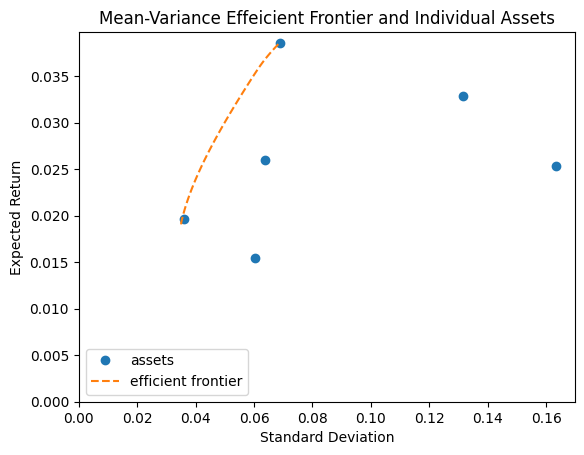

In [76]:
import matplotlib.pyplot as plt

plt.plot(np.sqrt(returns.drop(columns='date').var()), means, label = "assets", linestyle="None", marker="o")
plt.plot(np.sqrt(ef_variances), ef_returns, label = "efficient frontier", linestyle="--")

plt.legend()
plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")
plt.title("Mean-Variance Effeicient Frontier and Individual Assets")
plt.xlim(0)
plt.ylim(0)

plt.show()

In [77]:
ef_variances = np.array(ef_variances)
ef_returns = np.array(ef_returns)
ef_portfolios = np.array(ef_portfolios)

ef_risks = np.sqrt(ef_variances)

tickers = cov_matrix.columns.tolist()
rows = []
for i, (ret, risk, w) in enumerate(zip(ef_returns, ef_risks, ef_portfolios)):
    rows.append([i, ret, risk] + list(w))

cols = ["index", "return", "risk"] + tickers
df = pd.DataFrame(rows, columns=cols)

df.to_csv("efficient_frontier.tsv", sep="\t", index=False)

Submit "efficient_frontier.tsv" in Gradescope.

## Part 8: Check Maximum Return Portfolio Stability

Check the stability of the maximum return portfolio by resampling the estimated risk/return model.

Repeat 1000 times -
1. Use `np.random.multivariate_normal` to generate 23 return samples using your previously estimated risks and returns.
2. Estimate the return of each asset using that resampled return history.
3. Check which asset had the highest return in those resampled estimates.

This procedure is a reduced and simplified version of the Michaud resampled efficient frontier procedure that takes uncertainty in the risk model into account.

In [78]:
# YOUR CHANGES HERE

cov = pd.read_csv("estimated_covariance.tsv", sep="\t", index_col=0)
n_obs = 23  
n_trials = 1000

winners = []
for _ in range(n_trials):
    simulated = np.random.multivariate_normal(mean=mu, cov=cov.loc[assets, assets].values, size=n_obs)

    sample_means = simulated.mean(axis=0)

    best_asset = assets[np.argmax(sample_means)]
    winners.append(best_asset)

counts = pd.Series(winners).value_counts().reindex(assets, fill_value=0)
probs = counts / n_trials

In [81]:
winners

['TSLA',
 'TSLA',
 'MU',
 'TSLA',
 'MU',
 'MU',
 'COST',
 'AAPL',
 'MU',
 'TSLA',
 'TSLA',
 'MU',
 'AXP',
 'TSLA',
 'COST',
 'AXP',
 'AXP',
 'MU',
 'MU',
 'TSLA',
 'TSLA',
 'MU',
 'MU',
 'AXP',
 'MU',
 'AXP',
 'MU',
 'MU',
 'AXP',
 'TSLA',
 'MU',
 'COST',
 'MU',
 'MU',
 'TSLA',
 'MU',
 'AXP',
 'TSLA',
 'AXP',
 'COST',
 'MU',
 'TSLA',
 'MU',
 'MU',
 'COST',
 'MU',
 'AXP',
 'COST',
 'COST',
 'TSLA',
 'MU',
 'AXP',
 'AXP',
 'TSLA',
 'TSLA',
 'TSLA',
 'MU',
 'COST',
 'AXP',
 'TSLA',
 'AAPL',
 'AXP',
 'AXP',
 'AXP',
 'AXP',
 'MU',
 'MU',
 'AXP',
 'AXP',
 'AXP',
 'AXP',
 'AXP',
 'MU',
 'TSLA',
 'AXP',
 'TSLA',
 'TSLA',
 'COST',
 'AXP',
 'COST',
 'AXP',
 'TSLA',
 'TSLA',
 'MU',
 'COST',
 'TSLA',
 'MU',
 'COST',
 'AXP',
 'AXP',
 'AXP',
 'MU',
 'AXP',
 'TSLA',
 'MU',
 'TSLA',
 'COST',
 'TSLA',
 'AXP',
 'TSLA',
 'AXP',
 'TSLA',
 'TSLA',
 'COST',
 'AXP',
 'AXP',
 'MU',
 'MU',
 'COST',
 'MU',
 'COST',
 'COST',
 'MU',
 'COST',
 'MU',
 'AXP',
 'TSLA',
 'TSLA',
 'MU',
 'COST',
 'AXP',
 'COST',
 'AXP'

Save a file "max_return_probabilities.tsv" with the distribution of highest return assets.
The header row should have columns "asset" and "probability".
There should be a data row for each asset and its sample probability of having the highest return based on those 1000 resampled estimates.


In [82]:
# YOUR CHANGES HERE

df = pd.DataFrame({"asset": probs.index, "probability": probs.values})
df.to_csv("max_return_probabilities.tsv", sep="\t", index=False)

Submit "max_return_probabilities.tsv" in Gradescope.

## Part 9: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgements.txt" in Gradescope.

## Part 10: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.